In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 45 kB/s 
     |████████████████████████████████| 199 kB 62.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845514 sha256=ffc5ff2b27a4d4c0f6ca0a4b33e9fd322d922a34b84869558e62a796bf1babd9
  Stored in directory: /root/.cache/pip/wheels/42/59/f5/79a5bf931714dcd201b26025347785f087370a10a3329a899c
Successfully built pyspark


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, countDistinct

from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator

from pyspark.ml.stat import Correlation

**Load data set**

In [ ]:
spark=SparkSession.builder.appName("DataFrame").getOrCreate()

df1 = (spark.read
               .option("header", True)
             .csv("housepricedata.csv"))
df1.printSchema()

root
 |-- LotArea: string (nullable = true)
 |-- OverallQual: string (nullable = true)
 |-- OverallCond: string (nullable = true)
 |-- TotalBsmtSF: string (nullable = true)
 |-- FullBath: string (nullable = true)
 |-- HalfBath: string (nullable = true)
 |-- BedroomAbvGr: string (nullable = true)
 |-- TotRmsAbvGrd: string (nullable = true)
 |-- Fireplaces: string (nullable = true)
 |-- GarageArea: string (nullable = true)
 |-- AboveMedianPrice: string (nullable = true)



In [ ]:
# Convert String to Integer Type
df1=df1.withColumn("LotArea",df1.LotArea.cast(IntegerType()))
df1=df1.withColumn("OverallQual",df1.OverallQual.cast(IntegerType()))
df1=df1.withColumn("OverallCond",df1.OverallCond.cast(IntegerType()))
df1=df1.withColumn("TotalBsmtSF",df1.TotalBsmtSF.cast(IntegerType()))
df1=df1.withColumn("FullBath",df1.FullBath.cast(IntegerType()))
df1=df1.withColumn("HalfBath",df1.HalfBath.cast(IntegerType()))
df1=df1.withColumn("BedroomAbvGr",df1.BedroomAbvGr.cast(IntegerType()))
df1=df1.withColumn("TotRmsAbvGrd",df1.TotRmsAbvGrd.cast(IntegerType()))
df1=df1.withColumn("Fireplaces",df1.Fireplaces.cast(IntegerType()))
df1=df1.withColumn("GarageArea",df1.GarageArea.cast(IntegerType()))
df1=df1.withColumn("AboveMedianPrice",df1.AboveMedianPrice.cast(IntegerType()))

In [ ]:
df1.printSchema()

root
 |-- LotArea: integer (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- TotalBsmtSF: integer (nullable = true)
 |-- FullBath: integer (nullable = true)
 |-- HalfBath: integer (nullable = true)
 |-- BedroomAbvGr: integer (nullable = true)
 |-- TotRmsAbvGrd: integer (nullable = true)
 |-- Fireplaces: integer (nullable = true)
 |-- GarageArea: integer (nullable = true)
 |-- AboveMedianPrice: integer (nullable = true)



In [ ]:
df1.show()

+-------+-----------+-----------+-----------+--------+--------+------------+------------+----------+----------+----------------+
|LotArea|OverallQual|OverallCond|TotalBsmtSF|FullBath|HalfBath|BedroomAbvGr|TotRmsAbvGrd|Fireplaces|GarageArea|AboveMedianPrice|
+-------+-----------+-----------+-----------+--------+--------+------------+------------+----------+----------+----------------+
|   8450|          7|          5|        856|       2|       1|           3|           8|         0|       548|               1|
|   9600|          6|          8|       1262|       2|       0|           3|           6|         1|       460|               1|
|  11250|          7|          5|        920|       2|       1|           3|           6|         1|       608|               1|
|   9550|          7|          5|        756|       1|       0|           3|           7|         1|       642|               0|
|  14260|          8|          5|       1145|       2|       1|           4|           9|        

In [ ]:
df1.columns

['LotArea',
 'OverallQual',
 'OverallCond',
 'TotalBsmtSF',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageArea',
 'AboveMedianPrice']

**Descriptive statistic**

In [ ]:
df1.select(df1.columns).describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|summary|           LotArea|       OverallQual|       OverallCond|       TotalBsmtSF|          FullBath|           HalfBath|      BedroomAbvGr|      TotRmsAbvGrd|        Fireplaces|       GarageArea|  AboveMedianPrice|
+-------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-----------------+------------------+
|  count|              1460|              1460|              1460|              1460|              1460|               1460|              1460|              1460|              1460|             1460|              1460|
|   mean|10516.828082191782|6.0993150684931505| 5.575342465753424|1057.4294520547944|1.5650684931506849|0.38287671232876713|

In [ ]:
pd.DataFrame(df1.dtypes, columns = ['Column Name','Data type'])

,Column Name,Data type
0,LotArea,int
1,OverallQual,int
2,OverallCond,int
3,TotalBsmtSF,int
4,FullBath,int
5,HalfBath,int
6,BedroomAbvGr,int
7,TotRmsAbvGrd,int
8,Fireplaces,int
9,GarageArea,int


In [ ]:
#Check any missing value
for column in df1.columns:
    print(column, df1.filter(col(column).cast("float").isin([None,np.nan])).count())

LotArea 0
OverallQual 0
OverallCond 0
TotalBsmtSF 0
FullBath 0
HalfBath 0
BedroomAbvGr 0
TotRmsAbvGrd 0
Fireplaces 0
GarageArea 0
AboveMedianPrice 0


In [ ]:
# Count number of each target element
df1.groupBy('AboveMedianPrice').count().show()

+----------------+-----+
|AboveMedianPrice|count|
+----------------+-----+
|               1|  728|
|               0|  732|
+----------------+-----+



--> This is a balance data set.

In [ ]:
# Count distinct column values
for i in df1.columns:
  df1.select(countDistinct(i)).show()

+-----------------------+
|count(DISTINCT LotArea)|
+-----------------------+
|                   1073|
+-----------------------+

+---------------------------+
|count(DISTINCT OverallQual)|
+---------------------------+
|                         10|
+---------------------------+

+---------------------------+
|count(DISTINCT OverallCond)|
+---------------------------+
|                          9|
+---------------------------+

+---------------------------+
|count(DISTINCT TotalBsmtSF)|
+---------------------------+
|                        721|
+---------------------------+

+------------------------+
|count(DISTINCT FullBath)|
+------------------------+
|                       4|
+------------------------+

+------------------------+
|count(DISTINCT HalfBath)|
+------------------------+
|                       3|
+------------------------+

+----------------------------+
|count(DISTINCT BedroomAbvGr)|
+----------------------------+
|                           8|
+-------------------

**Visualization**

In [ ]:
df_visual=df1.toPandas()

Visualization of numeric variables

Text(0.5, 1.0, 'Lot area by Group of median price')

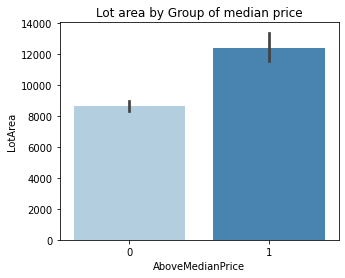

In [ ]:
# Lot area
plt.figure(figsize=(5,4))
sns.barplot(x='AboveMedianPrice',y='LotArea', color='AboveMedianPrice', data=df_visual, palette='Blues')
plt.title("Lot area by Group of median price")

Text(0.5, 1.0, 'Total basement square feet by Group of median price')

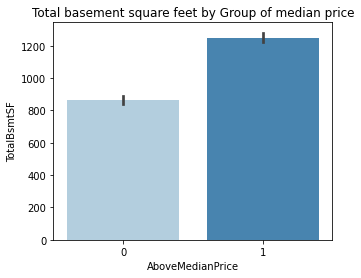

In [ ]:
# Total basement square feet
plt.figure(figsize=(5,4))
sns.barplot(x='AboveMedianPrice',y='TotalBsmtSF',data=df_visual, palette='Blues')
plt.title("Total basement square feet by Group of median price")

Text(0.5, 1.0, 'Garage area by Group of median price')

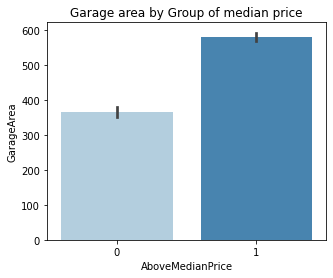

In [ ]:
# Garage area
plt.figure(figsize=(5,4))
sns.barplot(x='AboveMedianPrice',y='GarageArea',data=df_visual, palette='Blues')
plt.title("Garage area by Group of median price")

Visualization of categorical variables

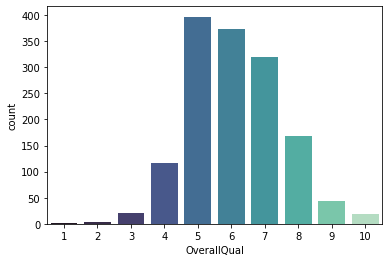

In [ ]:
# Overall quality 
sns.countplot(x='OverallQual', palette='mako', data=df_visual)
plt.show()

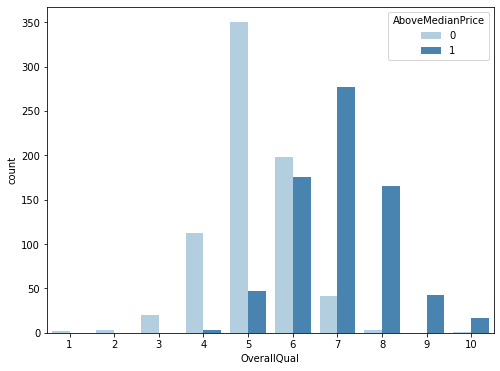

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x='OverallQual',hue='AboveMedianPrice',data=df_visual, palette='Blues')

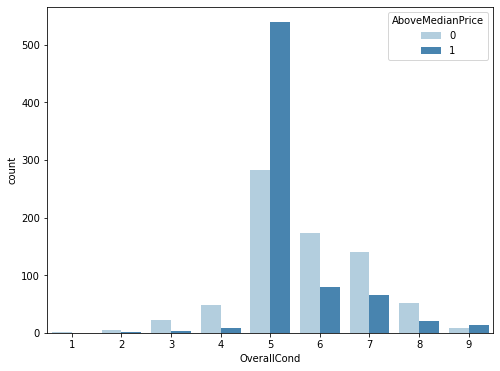

In [ ]:
# Overall Condition
plt.figure(figsize=(8,6))
sns.countplot(x='OverallCond',hue='AboveMedianPrice',data=df_visual, palette='Blues')

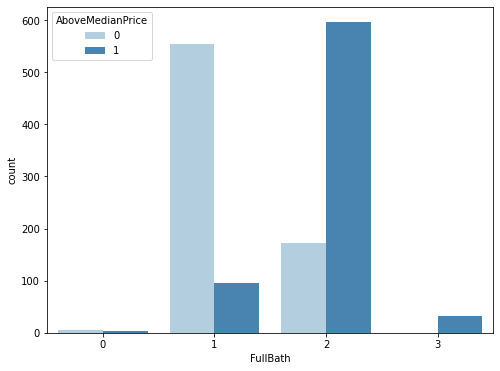

In [ ]:
# Full bath
plt.figure(figsize=(8,6))
sns.countplot(x='FullBath',hue='AboveMedianPrice',data=df_visual, palette='Blues')

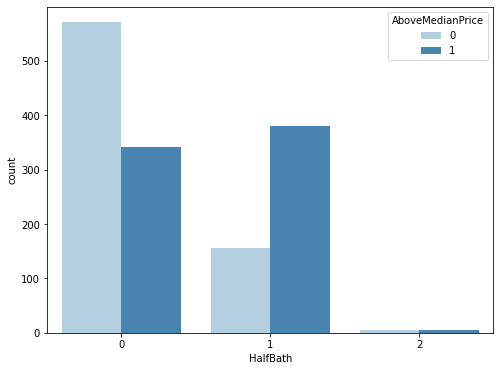

In [ ]:
# Half Bath
plt.figure(figsize=(8,6))
sns.countplot(x='HalfBath',hue='AboveMedianPrice',data=df_visual, palette='Blues')

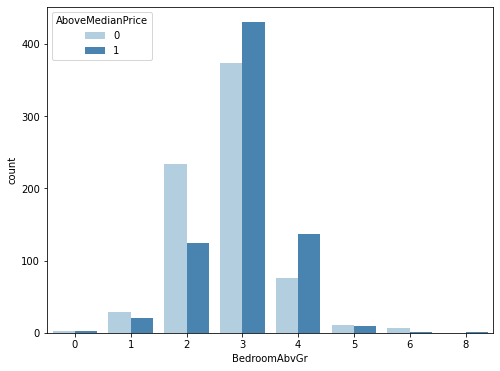

In [ ]:
# Bed room above ground
plt.figure(figsize=(8,6))
sns.countplot(x='BedroomAbvGr',hue='AboveMedianPrice',data=df_visual, palette='Blues')

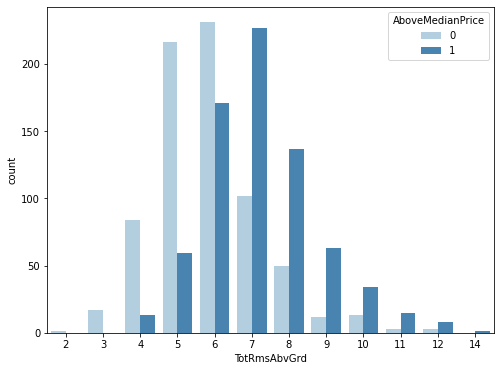

In [ ]:
# Total number of rooms above ground
plt.figure(figsize=(8,6))
sns.countplot(x='TotRmsAbvGrd',hue='AboveMedianPrice',data=df_visual, palette='Blues')

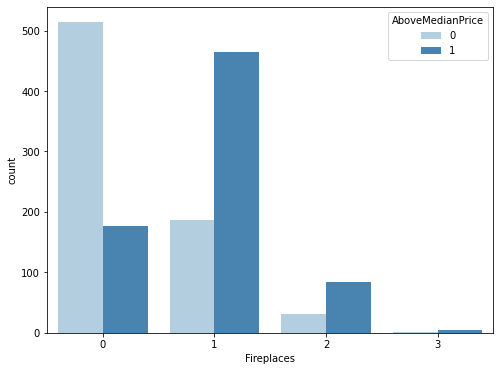

In [ ]:
# Fireplaces
plt.figure(figsize=(8,6))
sns.countplot(x='Fireplaces',hue='AboveMedianPrice',data=df_visual, palette='Blues')

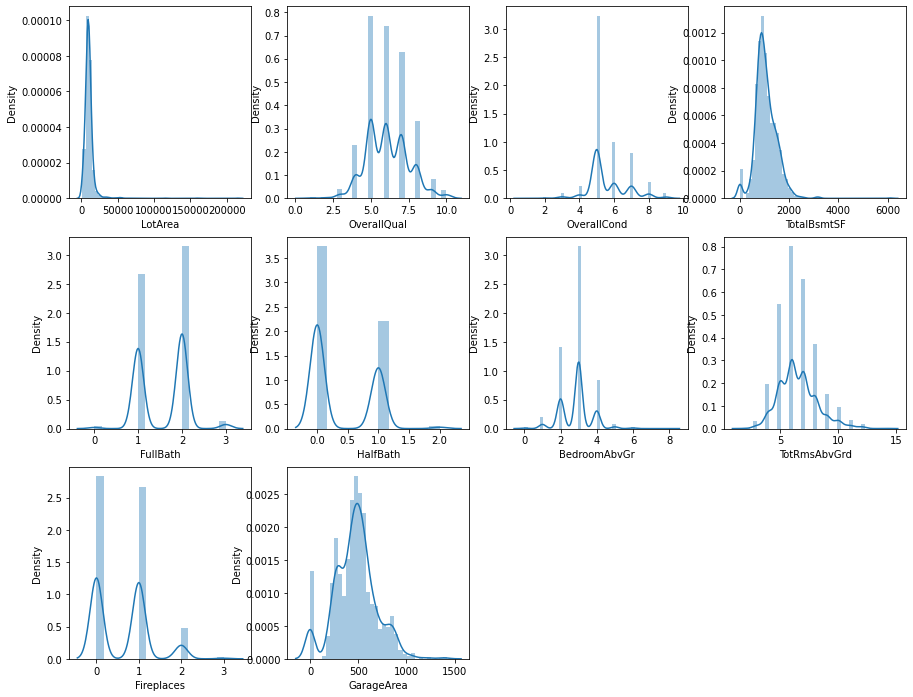

In [ ]:
# Density charts
plt.figure(figsize=(15,12))
def density(list_variables):
  x=1
  for i in list_variables:
    plt.subplot(3,4,x)
    sns.distplot(df_visual[i])
    x+=1

density(df1.columns[:-1])


**Correlation**

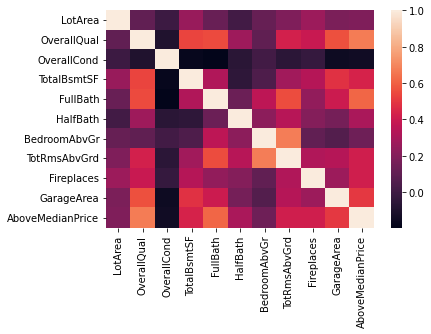

In [ ]:
# Convert to vector column first
assembler = VectorAssembler(inputCols=df1.columns, outputCol="features")
df_vector = assembler.transform(df1).select("features")

# Get correlation matrix
matrix = Correlation.corr(df_vector, 'features')
corrmatrix = matrix.collect()[0][0].toArray().tolist()

#Converst to pandas dataframe
df_corr = pd.DataFrame(corrmatrix, columns = df1.columns, index = df1.columns)

#plot correlation matrix by using seaborn
sns.heatmap(df_corr)

In [ ]:
# Feature importances
df_corr = pd.DataFrame(df_corr.iloc[:-1,-1])
df_corr = df_corr.reset_index()
df_corr.columns = ['Features', 'AboveMedianPrice']
print(df_corr)

       Features  AboveMedianPrice
0       LotArea          0.189180
1   OverallQual          0.672486
2   OverallCond         -0.141429
3   TotalBsmtSF          0.438301
4      FullBath          0.615951
5      HalfBath          0.308644
6  BedroomAbvGr          0.144853
7  TotRmsAbvGrd          0.417355
8    Fireplaces          0.420297
9    GarageArea          0.505068


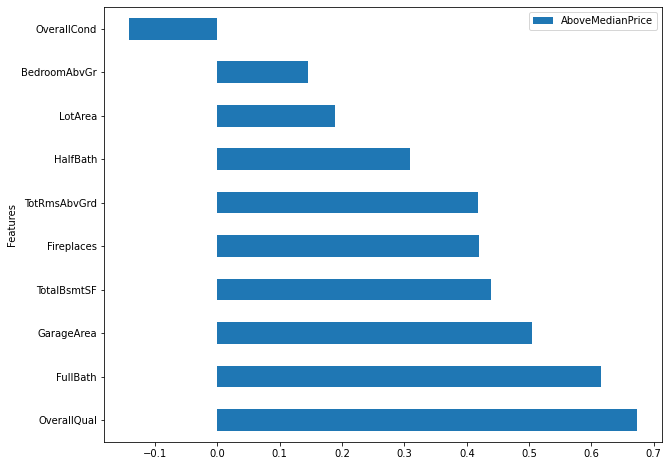

In [ ]:
df_corr.sort_values(by = ['AboveMedianPrice'], ascending=False).plot(figsize=(10,8), x="Features", y = "AboveMedianPrice", kind="barh")

**Scaling data set**

In [ ]:
# Assembling features
feature_assembly = VectorAssembler(inputCols = ['LotArea','OverallQual', 'OverallCond', 'TotalBsmtSF', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea'], outputCol = 'features')
output = feature_assembly.transform(df1)
output.show(3)

# Normalizing the features
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures",
                        withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(output)

# Normalize each feature to have unit standard deviation.
scaledOutput = scalerModel.transform(output)
scaledOutput.show(3)

+-------+-----------+-----------+-----------+--------+--------+------------+------------+----------+----------+----------------+--------------------+
|LotArea|OverallQual|OverallCond|TotalBsmtSF|FullBath|HalfBath|BedroomAbvGr|TotRmsAbvGrd|Fireplaces|GarageArea|AboveMedianPrice|            features|
+-------+-----------+-----------+-----------+--------+--------+------------+------------+----------+----------+----------------+--------------------+
|   8450|          7|          5|        856|       2|       1|           3|           8|         0|       548|               1|[8450.0,7.0,5.0,8...|
|   9600|          6|          8|       1262|       2|       0|           3|           6|         1|       460|               1|[9600.0,6.0,8.0,1...|
|  11250|          7|          5|        920|       2|       1|           3|           6|         1|       608|               1|[11250.0,7.0,5.0,...|
+-------+-----------+-----------+-----------+--------+--------+------------+------------+----------+

**Train-test split**

In [ ]:
df_model_final = scaledOutput.select(['scaledFeatures', 'AboveMedianPrice'])
df_model_final=df_model_final.withColumnRenamed("AboveMedianPrice","label")
df_model_final.show()

+--------------------+-----+
|      scaledFeatures|label|
+--------------------+-----+
|[0.84658608475447...|    1|
|[0.96180194244295...|    1|
|[1.12711165130033...|    1|
|[0.95679255732606...|    0|
|[1.42867663533713...|    1|
|[1.41414941849815...|    0|
|[1.01029279037445...|    1|
|[1.04014872567111...|    1|
|[0.61314873830738...|    0|
|[0.74339275134653...|    0|
|[1.12210226618344...|    0|
|[1.19463816267601...|    1|
|[1.29923412391668...|    0|
|[1.06719940530232...|    1|
|[1.09404970952885...|    0|
|[0.61314873830738...|    0|
|[1.12620996197929...|    0|
|[1.08112549592728...|    0|
|[1.37207058351627...|    0|
|[0.75741902967382...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
df_model_final.show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|scaledFeatures                                                                                                                                                                           |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|[0.8465860847544746,5.061473231073745,4.493173059188071,1.9511958307200363,3.6303188169538245,1.988524696873785,3.67747087769085,4.921885703813485,0.0,2.56308508392449]                 |1    |
|[0.9618019424429534,4.338405626634639,7.189076894700913,2.8766461896830444,3.6303188169538245,0.0,3.67747087769085,3.691414277860114,1.5511899196736965,2.1514947784767617]              |1    |
|[1.127111651300336,5.06147323

In [ ]:
df_train, df_test = df_model_final.randomSplit([0.8, 0.2], seed=10)

In [ ]:
print("Training Dataset Count: " + str(df_train.count()))
print("Test Dataset Count: " + str(df_test.count()))

Training Dataset Count: 1157
Test Dataset Count: 303


**Logistic Regression**

In [ ]:
lr = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'label', maxIter=10)
lrModel = lr.fit(df_train)

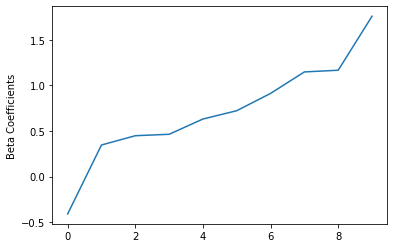

In [ ]:
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

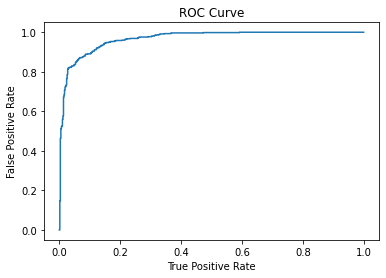

Training set areaUnderROC: 0.9669630904570672


In [ ]:
# ROC plot
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

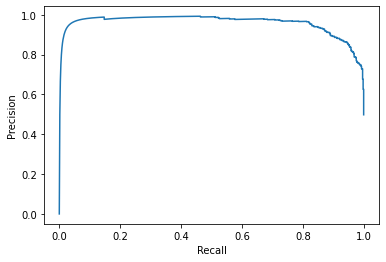

In [ ]:
# Precision and Recall
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# Make predictions on the test set
predictions_lr = lrModel.transform(df_test)
predictions_lr.select('scaledFeatures', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|      scaledFeatures|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.14797723635294...|    0|[7.74590062915476...|       0.0|[0.99956767504748...|
|[0.15288643376749...|    0|[6.49438844323838...|       0.0|[0.99849038284647...|
|[0.15989957293114...|    0|[7.68840401136296...|       0.0|[0.99954210104258...|
|[0.16831533992751...|    0|[4.02710210318508...|       0.0|[0.98248628512213...|
|[0.16831533992751...|    0|[3.89036308004305...|       0.0|[0.97997141853921...|
|[0.16831533992751...|    0|[2.81690871894911...|       0.0|[0.94358272952814...|
|[0.22722570890214...|    1|[0.25004212903189...|       0.0|[0.56218687024925...|
|[0.22842796133020...|    1|[-0.5442316063137...|       1.0|[0.36720375301300...|
|[0.23123321699566...|    0|[-0.7073405439006...|       1.0|[0.33018674885061...|
|[0.237244479135

In [ ]:
# Evaluate Logistic Regression model
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions_lr))

Test Area Under ROC 0.9723335657023353


In [ ]:
predictions_lr.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN_lr = predictions_lr.filter('prediction = 0 AND label = prediction').count()
TP_lr = predictions_lr.filter('prediction = 1 AND label = prediction').count()
FN_lr = predictions_lr.filter('prediction = 0 AND label = 1').count()
FP_lr = predictions_lr.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy_lr = (TN_lr + TP_lr) / (TN_lr + TP_lr + FN_lr + FP_lr)
print('Accuracy of Logistic Regression model', accuracy_lr)

# Calculate precision and recall
precision_lr = TP_lr / (TP_lr + FP_lr)
recall_lr = TP_lr / (TP_lr + FN_lr)
print('Precision {:.2f}\nRecall {:.2f}'.format(precision_lr, recall_lr))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   11|
|    0|       0.0|  137|
|    1|       1.0|  141|
|    0|       1.0|   14|
+-----+----------+-----+

Accuracy of Logistic Regression model 0.9174917491749175
Precision 0.91
Recall 0.93


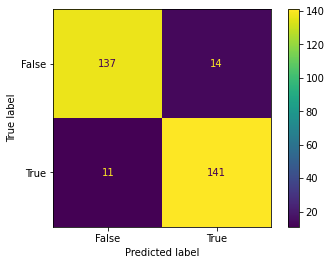

In [ ]:
# Draw confusion matrix of Logistic Regression model
cf_lr = predictions_lr.select(['label', 'prediction']).toPandas()
confusion_matrix_lr = metrics.confusion_matrix(cf_lr['label'], cf_lr['prediction'])

cm_display_lr = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_lr, display_labels = [False, True])

cm_display_lr.plot()
plt.show()

In [ ]:
# Feature importance in logistic regression


**Random Forest Classifier**

In [ ]:
rf = RandomForestClassifier(featuresCol = 'scaledFeatures', labelCol = 'label')
rfModel = rf.fit(df_train)
predictions_rf = rfModel.transform(df_test)
predictions_rf.select('scaledFeatures', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+--------------------+-----+--------------------+----------+--------------------+
|      scaledFeatures|label|       rawPrediction|prediction|         probability|
+--------------------+-----+--------------------+----------+--------------------+
|[0.14797723635294...|    0|[19.3226434535046...|       0.0|[0.96613217267523...|
|[0.15288643376749...|    0|[19.3226434535046...|       0.0|[0.96613217267523...|
|[0.15989957293114...|    0|[19.3226434535046...|       0.0|[0.96613217267523...|
|[0.16831533992751...|    0|[18.5344672428367...|       0.0|[0.92672336214183...|
|[0.16831533992751...|    0|[18.5344672428367...|       0.0|[0.92672336214183...|
|[0.16831533992751...|    0|[18.5344672428367...|       0.0|[0.92672336214183...|
|[0.22722570890214...|    1|[9.07600096145551...|       1.0|[0.45380004807277...|
|[0.22842796133020...|    1|[8.13625267544427...|       1.0|[0.40681263377221...|
|[0.23123321699566...|    0|[8.51909501358785...|       1.0|[0.42595475067939...|
|[0.237244479135

In [ ]:
# Evaluate Random Forest Classifier
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions_rf, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9739238410596022


In [ ]:
predictions_rf.groupBy('label', 'prediction').count().show()

# Calculate the elements of the confusion matrix
TN_rf = predictions_rf.filter('prediction = 0 AND label = prediction').count()
TP_rf = predictions_rf.filter('prediction = 1 AND label = prediction').count()
FN_rf = predictions_rf.filter('prediction = 0 AND label = 1').count()
FP_rf = predictions_rf.filter('prediction = 1 AND label = 0').count()

# Accuracy measures the proportion of correct predictions
accuracy_rf = (TN_rf + TP_rf) / (TN_rf + TP_rf + FN_rf + FP_rf)
print('Accuracy of Logistic Regression model', accuracy_rf)

# Calculate precision and recall
precision_rf = TP_rf / (TP_rf + FP_rf)
recall_rf = TP_rf / (TP_rf + FN_rf)
print('Precision {:.2f}\nRecall {:.2f}'.format(precision_rf, recall_rf))

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   17|
|    0|       0.0|  142|
|    1|       1.0|  135|
|    0|       1.0|    9|
+-----+----------+-----+

Accuracy of Logistic Regression model 0.9141914191419142
Precision 0.94
Recall 0.89


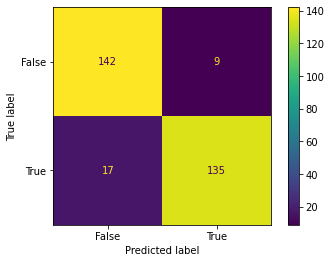

In [ ]:
# Draw confusion matrix of Logistic Regression model
cf_rf = predictions_rf.select(['label', 'prediction']).toPandas()
confusion_matrix_rf = metrics.confusion_matrix(cf_rf['label'], cf_rf['prediction'])

cm_display_rf = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf, display_labels = [False, True])

cm_display_rf.plot()
plt.show()

**Comments**:

Both Logistic Regression and Random Forest models give similarly high scores on the 'housepricedata' dataset. 

- Logistic Regression: Accuracy (91.75%), AUC (97.23%), Precision (91%), Recall (93%)

- Random Forest: Accuracy (90.76%), AUC (97.24%), Precision (94%), Recall (87%)

Since the purpose of this model is to predict house prices whether they are higher (TRUE) or lower (FALSE) than the Median Price (the 'AboveMedianPrice' column). Therefore, we should minimize the number of FALSE NEGATIVE (FN) forecasts. It helps the investors, or property buyers can anticipate their budget. Also, it helps the real estate agents can figure the suitable customer segment out.

Based on the confusion matrixes, we see that the Logistic Regression model gives less FALSE NEGATIVE observes than the Random Forest model (11 wrong predictions of Logistic Regression are less than 20 wrong predictions of Random Forest).

--> Logistic Regression model is better for this purpose.